In [10]:
#Data
import pandas as pd
import json

with open('linkedin-cvs-annotated.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)


In [11]:

dataset = []

for person_jobs in data:
    features = {}

    
    features['num_jobs'] = len(person_jobs)
    features['active_roles'] = sum(1 for j in person_jobs if j.get('status') == 'ACTIVE')

    
    
    active_jobs = [j for j in person_jobs if j.get('status') == 'ACTIVE']
    
    
    
    active_jobs.sort(key=lambda x: x.get('startDate') or "", reverse=True)

    if active_jobs:
        current_job = active_jobs[0]
        
        features['current_department'] = current_job.get('department')
        features['current_seniority'] = current_job.get('seniority')
        features['current_title'] = current_job.get('position') 
    else:
        
        features['current_department'] = "Unemployed/Unknown"
        features['current_seniority'] = "Unknown"
        features['current_title'] = None

    dataset.append(features)


X = pd.DataFrame(dataset)


print(X.head())

   num_jobs  active_roles      current_department current_seniority  \
0         6             5                   Other        Management   
1         8             1  Information Technology      Professional   
2         3             1              Consulting      Professional   
3         7             3    Business Development          Director   
4         8             1          Administrative              Lead   

                    current_title  
0                       Prokurist  
1             Solutions Architect  
2         Medizintechnik Beratung  
3  Director expansión de negocio.  
4        APL-ansvarig, samordning  


In [12]:

all_jobs = [job for person in data for job in person]
df_all_jobs = pd.DataFrame(all_jobs)

print("--- Department Distribution ---")
print(df_all_jobs['department'].value_counts())

print("\n--- Seniority Distribution ---")
print(df_all_jobs['seniority'].value_counts())

--- Department Distribution ---
department
Other                     1252
Information Technology     312
Sales                      219
Consulting                 195
Project Management         175
Marketing                  133
Administrative              84
Business Development        78
Purchasing                  72
Human Resources             70
Customer Support            48
Name: count, dtype: int64

--- Seniority Distribution ---
seniority
Professional    1219
Lead             460
Management       418
Junior           230
Senior           170
Director         141
Name: count, dtype: int64


In [13]:
import pandas as pd
import json



dept_df = pd.read_csv('department-v2.csv')
sen_df = pd.read_csv('seniority-v2.csv')



dept_rules = list(zip(dept_df['text'].str.lower(), dept_df['label']))

sen_rules = list(zip(sen_df['text'].str.lower(), sen_df['label']))



dept_rules.sort(key=lambda x: len(x[0]), reverse=True)
sen_rules.sort(key=lambda x: len(x[0]), reverse=True)

def apply_rules(title, rules, default="Other"):
 
    if not title:
        return default
    
    title_lower = title.lower()
    
    for keyword, label in rules:
        
        
        if keyword in title_lower:
            return label
            
    return default



annotated_data = []

for person_jobs in data:
    
    active_jobs = [j for j in person_jobs if j.get('status') == 'ACTIVE']
    active_jobs.sort(key=lambda x: x.get('startDate') or "", reverse=True)
    
    current_title = ""
    if active_jobs:
        current_title = active_jobs[0].get('position', "")

    
    predicted_dept = apply_rules(current_title, dept_rules, default="Unknown")
    predicted_seniority = apply_rules(current_title, sen_rules, default="Unknown")

    
    annotated_data.append({
        'title': current_title,
        'predicted_dept': predicted_dept,
        'predicted_seniority': predicted_seniority
    })


df_results = pd.DataFrame(annotated_data)
print(df_results.head())

                            title          predicted_dept predicted_seniority
0                       Prokurist                 Unknown             Unknown
1             Solutions Architect  Information Technology             Unknown
2         Medizintechnik Beratung                 Unknown             Unknown
3  Director expansión de negocio.                 Unknown            Director
4        APL-ansvarig, samordning                 Unknown             Unknown


In [14]:
import pandas as pd
import json
from sklearn.metrics import accuracy_score, classification_report



dept_df = pd.read_csv('department-v2.csv')
sen_df = pd.read_csv('seniority-v2.csv')




dept_rules = sorted(list(zip(dept_df['text'].str.lower(), dept_df['label'])), key=lambda x: len(x[0]), reverse=True)
sen_rules = sorted(list(zip(sen_df['text'].str.lower(), sen_df['label'])), key=lambda x: len(x[0]), reverse=True)



def apply_rules(title, rules, default="Other"):
    if not title:
        return default
    title_lower = title.lower()
    for keyword, label in rules:
        
        if keyword in title_lower:
            return label
    return default



results = []

for person_jobs in data:
    
    active_jobs = [j for j in person_jobs if j.get('status') == 'ACTIVE']
    active_jobs.sort(key=lambda x: x.get('startDate') or "", reverse=True)
    
    if active_jobs:
        current_job = active_jobs[0]
        title = current_job.get('position', "")
        
        
        actual_dept = current_job.get('department', 'Unknown')
        actual_seniority = current_job.get('seniority', 'Unknown')
        
        
        pred_dept = apply_rules(title, dept_rules, default="Other")
        pred_seniority = apply_rules(title, sen_rules, default="Professional")
        
        results.append({
            'title': title,
            'actual_dept': actual_dept,
            'pred_dept': pred_dept,
            'actual_seniority': actual_seniority,
            'pred_seniority': pred_seniority,
            
            'dept_correct': actual_dept == pred_dept,
            'seniority_correct': actual_seniority == pred_seniority
        })


df_res = pd.DataFrame(results)



acc_dept = accuracy_score(df_res['actual_dept'], df_res['pred_dept'])
acc_sen = accuracy_score(df_res['actual_seniority'], df_res['pred_seniority'])

print(f"Department Accuracy: {acc_dept:.2%}")
print(f"Seniority Accuracy:  {acc_sen:.2%}")



print("--- Department Report ---")
print(classification_report(df_res['actual_dept'], df_res['pred_dept'], zero_division=0))

print("--- Seniority Report ---")
print(classification_report(df_res['actual_seniority'], df_res['pred_seniority'], zero_division=0))



errors = df_res[~df_res['dept_correct']].head(5)
if not errors.empty:
    print(errors[['title', 'actual_dept', 'pred_dept']])
else:
    print("No errors found!")

Department Accuracy: 62.13%
Seniority Accuracy:  54.60%
--- Department Report ---
                        precision    recall  f1-score   support

        Administrative       0.50      0.10      0.17        10
  Business Development       0.60      0.33      0.43        18
            Consulting       0.90      0.64      0.75        28
      Customer Support       0.00      0.00      0.00         6
       Human Resources       0.00      0.00      0.00        16
Information Technology       0.22      0.31      0.26        55
             Marketing       0.80      0.42      0.55        19
                 Other       0.66      0.83      0.73       246
    Project Management       0.79      0.48      0.60        31
            Purchasing       1.00      0.50      0.67        12
                 Sales       0.92      0.62      0.74        37

              accuracy                           0.62       478
             macro avg       0.58      0.39      0.44       478
          weighted a

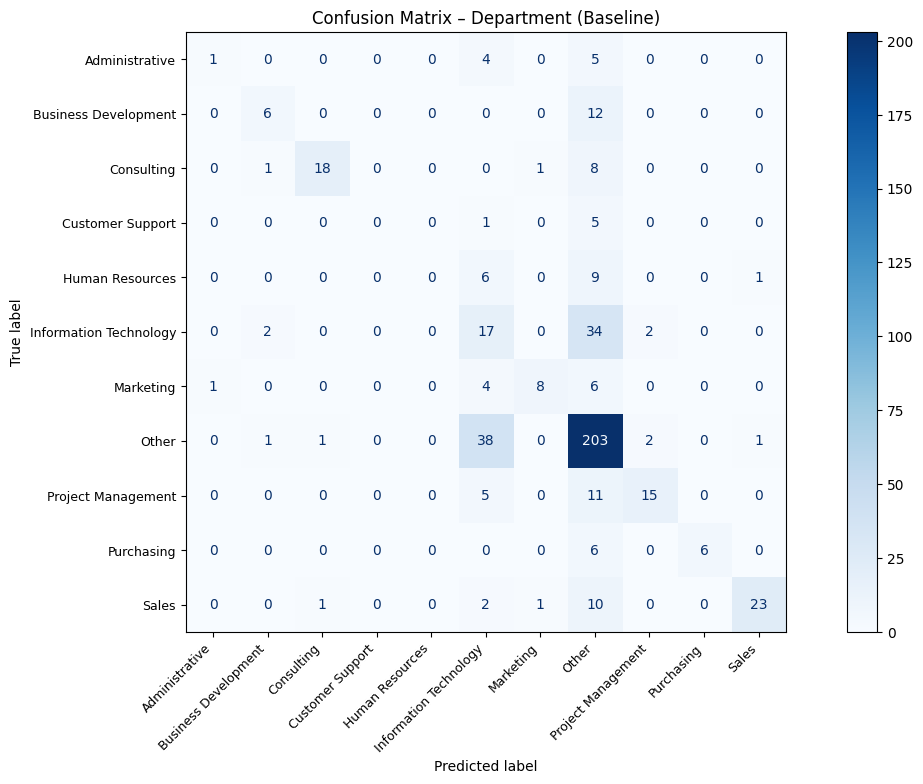

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [
    "Administrative",
    "Business Development",
    "Consulting",
    "Customer Support",
    "Human Resources",
    "Information Technology",
    "Marketing",
    "Other",
    "Project Management",
    "Purchasing",
    "Sales"
]

cm_dept = confusion_matrix(df_res["actual_dept"], df_res["pred_dept"], labels=labels)

fig, ax = plt.subplots(figsize=(18, 10)) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dept, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

ax.set_title("Confusion Matrix – Department (Baseline)")

fig.subplots_adjust(bottom=0.28, left=0.22)

plt.show()




<Figure size 800x600 with 0 Axes>

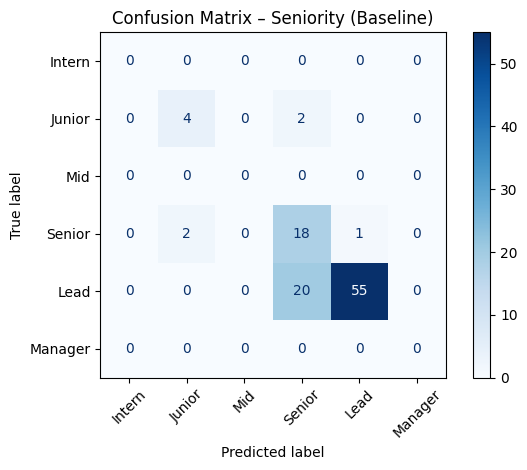

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

seniority_labels = [
    "Intern",
    "Junior",
    "Mid",
    "Senior",
    "Lead",
    "Manager"
]

cm_sen = confusion_matrix(
    df_res["actual_seniority"],
    df_res["pred_seniority"],
    labels=seniority_labels
)

plt.figure(figsize=(8, 6))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_sen,
    display_labels=seniority_labels 
)

disp.plot(
    xticks_rotation=45,
    cmap="Blues",
    values_format="d"
)

plt.title("Confusion Matrix – Seniority (Baseline)")
plt.tight_layout()
plt.show()



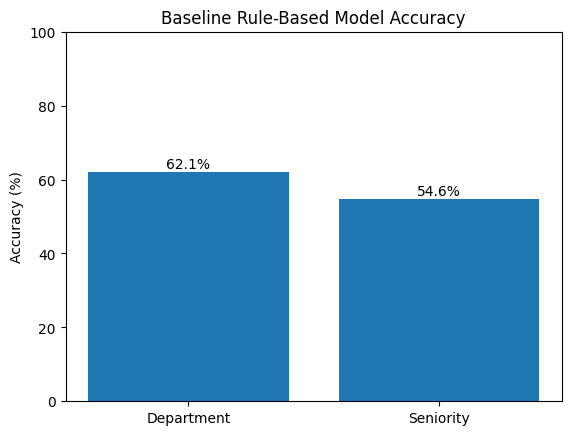

In [17]:
import matplotlib.pyplot as plt

# Accuracy values 
acc_dept = 62.13
acc_sen = 54.60

labels = ["Department", "Seniority"]
values = [acc_dept, acc_sen]

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Rule-Based Model Accuracy")

# percentage labels on  the bar
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center")

plt.show()
